# PCS5024 - Aprendizado Estatístico - Statistical Learning - 2023/1
### Professors: 
### Anna Helena Reali Costa (anna.reali@usp.br)
### Fabio G. Cozman (fgcozman@usp.br)

In [1]:
!pip install --quiet torch numpy pandas gdown uniplot matplotlib

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import gdown
from tqdm import tqdm
import uniplot

# Recurrent Neural Networks

Recurrent Neural Networks (RNNs) is a family of neural network specifically designed for processing sequential data (Rumelhart et al., 1986a). They can handle sequences of variable length and share parameters across different parts of the model, making them more adaptable to different input forms. RNNs can generalize across different sequence lengths and positions in time, which is particularly important when specific information can occur at multiple positions within a sequence.

In contrast to traditional fully connected feedforward networks, RNNs share the same weights across several time steps. This allows the network to learn language rules at each position in the sequence without having to relearn them separately. Convolution across a 1-D temporal sequence is another related idea, used in Time-Delay Neural Networks (TDNNs) (Lang and Hinton, 1988; Waibel et al., 1989; Lang et al., 1990). While convolution allows for parameter sharing across time, it is shallow compared to the deep computational graph sharing in RNNs.

**Sharing weights is an idea from 1980s ML and is still very commonly used in Deep Learning!**

In general, a RNN can be represented as following:

<img src='https://drive.google.com/uc?id=14x9VlBRucvDCwBqS00xjOYWoYqVuMb3w'  width="40%" height="40%">

The transformations U, W and V are shared for all $x$ the same way CNNs share the same set of kernels for the whole image.

RNNs compute a new hidden state $h$ for each new input $x$:

$h^{(t)} = f(h^{(t-1)},x^{(t)},\theta)$

There are several RNNs models. The most common are:

<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*B0q2ZLsUUw31eEImeVf3PQ.png"   width="60%" height="60%">

In this notebook we'll use the Gated Recurrent Unit or GRU (Chung et al. 2014) architecture to show how RNNs can be used in a forecast task.


$r_t = \sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
z_t = \sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\
h_t = (1 - z_t) * n_t + z_t * h_{(t-1)}$

Let's see an example of a sequence of GPS measurements (2 features) being processed by an RNN with hidden size 4.

<img src='https://drive.google.com/uc?id=1EbcmMY7pvodQO_8a9mUNOu2ahggvDSEc'  width="60%" height="60%" align="left">

To further illustrate how RNNs can be used now we'll use sea surface height (SSH) measurements extracted from the Santos Port Channel dataset. This dataset is a collection of measurements from several sensors, but we're only interested in SSH.

In [3]:
id = "1qZv6wwHLyMIZQQNQN8NN676AIgF-XJt5"
gdown.download(id=id, output="santos_ssh.csv", quiet=False)

df = pd.read_csv("santos_ssh.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
train_df = df[df["datetime"].dt.tz_convert(None) < np.datetime64("2020-06-01 00:00:00")]
test_df = df[df["datetime"].dt.tz_convert(None) >= np.datetime64("2020-06-01 00:00:00")]
train_df.head(), test_df.head()

Downloading...
From: https://drive.google.com/uc?id=1qZv6wwHLyMIZQQNQN8NN676AIgF-XJt5
To: /home/marcel/projects/USP/Courses/test_notebook/santos_ssh.csv
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 792k/792k [00:00<00:00, 5.01MB/s]


(                   datetime   ssh
 0 2020-01-01 00:00:00+00:00  0.70
 1 2020-01-01 00:10:00+00:00  0.69
 2 2020-01-01 00:20:00+00:00  0.68
 3 2020-01-01 00:30:00+00:00  0.67
 4 2020-01-01 00:40:00+00:00  0.67,
                        datetime   ssh
 21293 2020-06-01 00:00:00+00:00  0.90
 21294 2020-06-01 00:10:00+00:00  0.92
 21295 2020-06-01 00:20:00+00:00  0.94
 21296 2020-06-01 00:30:00+00:00  0.99
 21297 2020-06-01 00:40:00+00:00  1.01)

<Axes: >

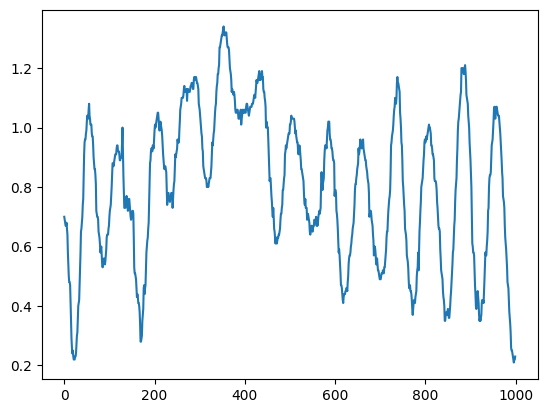

In [4]:
train_df["ssh"].iloc[:1000].plot()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 1
hidden_size = 64
num_epochs = 15
past_len = 800
future_len = 100
batch_size = 32
learning_rate = 1e-3

In [6]:
# Here we write a SimpleARModel that uses the network 
# output as the input for the next prediction step (i.e. no teacher forcing)
class SimpleARModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)

    def forward(self, x, target_seq_len):
        # encoding
        out, h_n = self.rnn(x)
        inp = self.linear(out[:, -1]).unsqueeze(1)

        output_seq = torch.empty(
            x.shape[0], target_seq_len, x.shape[-1], device=inp.device
        )

        for i in range(target_seq_len):
            out, h_n = self.rnn(inp, h_n)
            output_seq[:, i] = self.linear(out[:, -1])
        return output_seq


def create_sequences(data, past_len, future_len):
    xs, ys = [], []
    for i in range(past_len, len(data) - future_len):
        x = data[(i - past_len) : i]
        y = data[i : (i + future_len)]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [7]:
train_data = train_df["ssh"].values
test_data = test_df["ssh"].values

X_train, y_train = create_sequences(train_data, past_len, future_len)
X_test, y_test = create_sequences(test_data, past_len, future_len)

X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
model = SimpleARModel(input_size, hidden_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in tqdm(train_dataloader):
        inputs = inputs.unsqueeze(-1).to(device)
        targets = targets.unsqueeze(-1).to(device)

        outputs = model(inputs, targets.shape[1])
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(tqdm(test_dataloader)):
            inputs = inputs.unsqueeze(-1).to(device)
            targets = targets.unsqueeze(-1).to(device)

            outputs = model(inputs, targets.shape[1])
            test_loss = criterion(outputs, targets)
            past_view_size = 50
            if i in [0, 1, 2] and epoch % 3 == 0:
                inp = inputs[0, :, 0].cpu()
                tar = targets[0, :, 0].cpu()
                out = outputs[0, :, 0].cpu()
                uniplot.plot(
                    ys=[inp[-past_view_size:], tar, out],
                    xs=[
                        np.arange(0, past_view_size),
                        np.arange(past_view_size, past_view_size + len(tar)),
                        np.arange(past_view_size, past_view_size + len(tar)),
                    ],
                    color=True,
                    legend_labels=["Input", "Target", "Output"],
                    title=f"Epoch: {epoch + 1}, Test Loss: {test_loss.item():.4f} - Example {i}",
                    height=10
                )


 27%|██████████████████████████████████████▊                                                                                                        | 29/107 [00:00<00:00, 142.13it/s]

           Epoch: 1, Test Loss: 0.1097 - Example 0
┌────────────────────────────────────────────────────────────┐
│▛▚▄▄▄▄▖                     ▟▀▀▀▀▄                          │ 
││     ▚                   ▄▀      ▀▚                        │ 1
││      ▀▖                ▝          ▚▖                     ▄│ 
││       ▘▖              ▗▘           ▝▀▖               ▖▄▀▀▝│ 
││       ▝▝▄         ▗▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄│ 
││          ▚        ▞ ▗▘                 ▖          ▄▀▘     │ 0
││           ▚         ▞                  ▝▀▖     ▗▄▞        │ 
││           ▝▖      ▄                      ▀▀▀▄▄▄▘          │ 
││            ▗▄    ▗▝▀                                      │ 
││              ▀▄▄▄▘                                        │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output
           Epoch: 1, Test Loss

 24%|██████████████████████████████████▋                                                                                                            | 26/107 [00:00<00:00, 131.91it/s]

           Epoch: 4, Test Loss: 0.0623 - Example 0
┌────────────────────────────────────────────────────────────┐
│▛▚▄▄▄▄▖                     ▟▀▄▄▄▄                          │ 
││     ▚                   ▗▄▞▀    ▀▚▄                       │ 1
││      ▀▖               ▗▞▀         ▚▚▖                    ▄│ 
││       ▘▖            ▗▞▀▘           ▝▝▙               ▖▗▟▀▝│ 
││       ▝▝▄          ▄▀▗▀              ▚▀▖            ▗▞▘   │ 
││          ▚        ▞ ▗▘                 ▝▚▖        ▄▞▘     │ 0
││           ▚         ▞                  ▝▀▀▚▖   ▄▄▀        │ 
││           ▝▖      ▄                      ▀▀▝▀▀▀▘          │ 
││            ▗▄    ▗▝▀                                      │ 
││              ▀▄▄▄▘                                        │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output
           Epoch: 4, Test Loss

 24%|██████████████████████████████████▋                                                                                                            | 26/107 [00:00<00:00, 133.58it/s]

           Epoch: 7, Test Loss: 0.0192 - Example 0
┌────────────────────────────────────────────────────────────┐
│▛▚▄▄▄▄▖                     ▗▀▀▀▀▀▄▖                        │ 
││     ▚                   ▗▞▘     ▀▀▄                      ▗│ 1
││      ▀▖                ▄▀         ▚▙                  ▗▟▀▀│ 
││       ▘▖              ▟▘           ▝▚▖              ▄▞▘▀▀▝│ 
││       ▝▝▄           ▗▀▀              ▀▖           ▄▞▗▝    │ 
││          ▚        ▗▞▘▘                ▝▙        ▄▀▄▀▘     │ 0
││           ▄       ▘ ▝                  ▝▀▄▄  ▄▄▀▄▞        │ 
││           ▝▖      ▄ ▘                    ▀▀▀▀▄▄▀          │ 
││            ▗▄    ▗▝▀                                      │ 
││              ▀▄▄▄▘                                        │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output
           Epoch: 7, Test Loss

 24%|██████████████████████████████████▋                                                                                                            | 26/107 [00:00<00:00, 132.97it/s]

           Epoch: 10, Test Loss: 0.0420 - Example 0
┌────────────────────────────────────────────────────────────┐
││                           ▗▞▀▀▀▀▄▖                        │ 
│▄▄▄▖ ▄                     ▄▀▄▄▞▄▖ ▀▚▖                   ▄▄▄│ 
││ ▘▝▀ ▚                   ▐▞     ▀▀▙ ▚▖                ▟▀   │ 1
││      ▀▖                ▗▘         ▚▖▝▙             ▐▀  ▗▗▄│ 
││       ▚▄              ▗▘           ▝▀▖▚▖         ▗▞▘ ▄▄▀▘ │ 
││         ▀            ▞▞              ▀▚▀▄▖      ▄▀ ▄▞     │ 
││          ▀▖         ▗▞                 ▚▄▀▚▄▄▄▄▀ ▗▀       │ 0
││           ▐        ▗▞                    ▙▄▄▖▖ ▞▀▘        │ 
││            ▚▄    ▗▀▘                        ▝▝▀           │ 
││             ▝▀▄▄▄▘                                        │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output
           Epoch: 10, Test Lo

 26%|█████████████████████████████████████▍                                                                                                         | 28/107 [00:00<00:00, 139.86it/s]

           Epoch: 13, Test Loss: 0.0405 - Example 0
┌────────────────────────────────────────────────────────────┐
││                           ▗▀▀▀▀▀▚▖                        │ 
││                          ▄▘  ▗   ▝▚                    ▗▄▄│ 
│▀▀▛▚▄▀▖                   ▐▗▀▀▀▘▀▙▄▖ ▚▖                ▗▞▀  │ 
││     ▝▄                 ▞▘▘       ▀▖ ▝▖              ▄▀    │ 1
││       ▌▖              ▐▘          ▝▀▚▝▄            ▟  ▗▀▞▀│ 
││       ▝▝▄            ▗▘              ▚▄▚▖        ▄▀▖▗▀▘   │ 
││          ▚          ▗▘                 ▙▝▚▄▖ ▗▄▞▀▗▄▝▘     │ 0
││           ▜        ▗▞                    ▙▄▝▀▘ ▄▀▀        │ 
││            ▚▄     ▀▘                        ▀▀▀           │ 
││             ▝▀▄▄▄▀                                        │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output
           Epoch: 13, Test Lo

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 149.11it/s]


# The Challenge of Long-Term Dependencies

The basic problem is that gradients propagated over many stages tend to either vanish (most of the time) or explode (rarely, but with much damage to the optimization).

Recurrent networks involve the composition of the same function multiple times, once per time step.

In particular, the function composition employed by recurrent neural networks somewhat resembles matrix multiplication. We can think of the recurrence relation:

$h^{(t)} = W^Th^{(t-1)}$

as a very simple recurrent neural network lacking a nonlinear activation function and lacking inputs x. 
This recurrence relation essentially describes the power method. It may be simpliﬁed to:

$h^{(t)} = (W^t)^Th^{(0)}$

and if W admits an eigendecomposition of the form:

$W = Q \Lambda Q^T$

with orthogonal Q, the recurrence may be simpliﬁed further to:

$h^{(t)} = Q^T \Lambda^{t} Q h^{(0)}$

The eigenvalues are raised to the power of t, causing eigenvalues with magnitude less than one to decay to zero and eigenvalues with magnitude greater than one to explode. Any component of $h(0)$ that is not aligned with the largest eigenvector will eventually be discarded.

Several approaches have been proposed to tackle this. Namely:
- Adding Skip Connections through Time: One way to obtain coarse time scales is to add direct connections from variables in the distant past to variables in the present.
- Adding other controlled gates: This allows the network to accumulate information (such as evidence for a particular feature or category) over a long duration. Once that information has been used, however, it might be useful for the neural network to forget the old state.
- Gradient clipping: Prevents gradient explosion
- Many others...

# Exercise
A more comprehensive look into sequence modeling can be found at: https://www.deeplearningbook.org/contents/rnn.html

One of the strategies to train RNNs is called teacher forcing. This strategy allows for the network to use the actual label instead of its generated output as input to the next step. This allows for the gradient to be propagated through fewer steps in some networks and also for the network to slowly be able to use its own outputs.

Exercise:
Implement the **teacher forcing** mechanism and compare the results.